In [1]:
import os
import math
import torch
from dataclasses import dataclass, field

from code.train import train
from code.optimizers import Optimizer
from code.problems import Problem

%matplotlib widget
%load_ext autoreload
%autoreload 1

In [2]:
os.environ['MLFLOW_VERBOSE'] = 'True'
os.environ['MLFLOW_EXPERIMENT_NAME'] = os.path.basename(os.getcwd())

In [38]:
os.environ['MLFLOW_RUN_TAG'] = 'mnist'
@dataclass
class Config():
    n_iters: int = 50
    n_peers: int = 6
    # dim: int = 5

    # game: Game = Game.Quadratic
    problem: Problem = field(default_factory=lambda: Problem.Logistic)
    n_samples: int = 10000

    optimizer: Optimizer = field(default_factory=lambda: Optimizer.SGD)
    batch_size: int = 5
    lr: float = 1e-1
    md_full: bool = False
    md_iter: int = 10
    md_lr: int = 0.5

In [39]:
config = Config()
config.optimizer = Optimizer.SGD
os.environ['MLFLOW_RUN_NAME'] = config.optimizer.name
os.environ['MLFLOW_RUN_TITLE'] = ''
train(config)

Trying port 42877
2.35066294670105
1.57207441329956059         
1.23934555053710949         
1.02208113670349129         
0.88269519805908219         


In [40]:
config = Config()
config.optimizer = Optimizer.SGDMD
os.environ['MLFLOW_RUN_NAME'] = config.optimizer.name
os.environ['MLFLOW_RUN_TITLE'] = 'MDFullBatch=' + str(config.md_full)
train(config)

Trying port 44623
2.35066294670105
1.26050353050231939         
0.99479562044143689         
0.78933721780776989         
0.71362560987472539         


In [41]:
config = Config()
config.optimizer = Optimizer.SGDMD
config.md_full = True
os.environ['MLFLOW_RUN_NAME'] = config.optimizer.name
os.environ['MLFLOW_RUN_TITLE'] = 'MDFullBatch=' + str(config.md_full)
train(config)

Trying port 4947
2.35066294670105
1.21898686885833749         
0.94506067037582439         
0.76429927349090589         
0.67738258838653569         


In [101]:
from PIL import Image
class MyIterableDataset(dsets.MNIST):
    def __init__(self, **args):
        super().__init__(**args)

    def __getitem__(self, index: int):# -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        print(index)
        # index = 0
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [115]:
dataset = MyIterableDataset(root='/tmp', 
                            # train=Tr, 
                            transform=transforms.ToTensor(),
                            download=True)

per_worker = int(math.ceil(len(dataset) / float(config.n_peers)))
worker_id = 1
beg = worker_id * per_worker
end = min(beg + per_worker, len(dataset)-1)
dataset.targets= dataset.targets[beg:end]
dataset.data = dataset.data[beg:end]

dataset.targets = dataset.targets.clone().detach()
idx = dataset.targets==2
dataset.targets= dataset.targets[idx]
dataset.data = dataset.data[idx]


train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=1, 
                                           shuffle=True)


2383


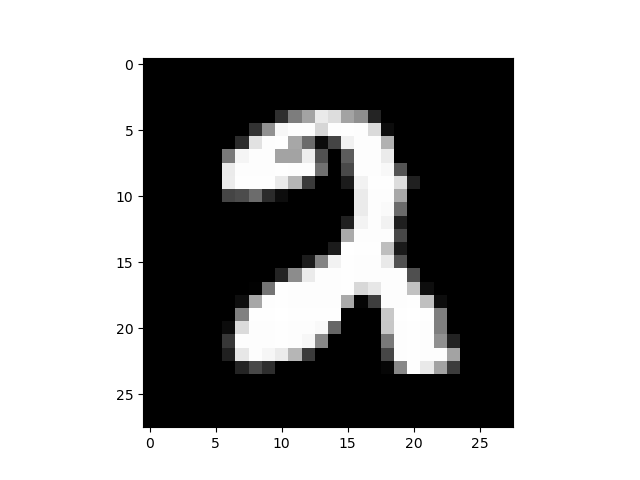

In [122]:
import matplotlib.pyplot as plt
# %matplotlib inline  
import numpy as np
# torch.manual_seed(0)
show_img = next(iter(train_loader))[0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')
plt.show()

In [117]:
import torch
import math
from torch.utils.data import DataLoader


class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end > start, "this example code only works with end >= start"
        self.start = start
        self.end = end

    def __iter__(self):
        return iter(range(self.start, self.end))


# Define a `worker_init_fn` that configures each dataset copy differently
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset  # the dataset copy in this worker process
    overall_start = dataset.start
    overall_end = dataset.end
    # configure the dataset to only process the split workload
    per_worker = int(math.ceil((overall_end - overall_start) / float(worker_info.num_workers)))
    worker_id = 0
    dataset.start = overall_start + worker_id * per_worker
    dataset.end = min(dataset.start + per_worker, overall_end)



ds = MyIterableDataset(start=0, end=500)

dl = DataLoader(
    dataset=ds, batch_size=100, shuffle=True, num_workers=2, worker_init_fn=worker_init_fn,
)

for e in dl:
    print(e)
        

ValueError: DataLoader with IterableDataset: expected unspecified shuffle option, but got shuffle=True